In [1]:
import requests
from datetime import datetime, timedelta
import json
import pandas as pd

url = 'https://api.binance.com/api/v3/klines'
symbol = 'BTCUSDT'
interval = '1d'
period = datetime.now() - timedelta(450)

data_start = int(period.timestamp()*1000)
date_end = int(datetime.now().timestamp()*1000)

parametres = {
    'symbol' : symbol,
    'interval' : interval,
    'startTime' : data_start,
    'endTime' : date_end
}

res = json.loads(requests.get(url,params = parametres).text)
df= pd.DataFrame(res)
df.columns = ['datetime','open','high','low','close','volume','close_time','qav','num_trades','taker_base_vol','taker_quote_vol','ignore']
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

df.head()

,datetime,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,2021-12-16,48864.98000000,49436.43000000,47511.00000000,47632.38000000,31949.86739000,1639699199999,1551200654.05274500,1023983,15281.92439000,742115283.57739880,0
1,2021-12-17,47632.38000000,47995.96000000,45456.00000000,46131.20000000,43104.48870000,1639785599999,2015966349.51613240,1261780,19846.77192000,928665863.58507440,0
2,2021-12-18,46133.83000000,47392.37000000,45500.00000000,46834.48000000,25020.05271000,1639871999999,1165205135.70084270,862066,12635.54707000,588649454.27256670,0
3,2021-12-19,46834.47000000,48300.01000000,46406.91000000,46681.23000000,29305.70665000,1639958399999,1384958598.36276990,874827,14646.77828000,692559814.22856370,0
4,2021-12-20,46681.24000000,47537.57000000,45558.85000000,46914.16000000,35848.50609000,1640044799999,1663363117.83045340,1076488,17666.32749000,819817570.66374300,0


In [2]:
df.drop(['close_time','qav','taker_base_vol','taker_quote_vol','ignore','num_trades'],axis=1,inplace=True)#Just dropping columns here!
df.head()

,datetime,open,high,low,close,volume
0,2021-12-16,48864.98000000,49436.43000000,47511.00000000,47632.38000000,31949.86739000
1,2021-12-17,47632.38000000,47995.96000000,45456.00000000,46131.20000000,43104.48870000
2,2021-12-18,46133.83000000,47392.37000000,45500.00000000,46834.48000000,25020.05271000
3,2021-12-19,46834.47000000,48300.01000000,46406.91000000,46681.23000000,29305.70665000
4,2021-12-20,46681.24000000,47537.57000000,45558.85000000,46914.16000000,35848.50609000


In [ ]:
df.isnull().any()#We don't have any NaN values luckily

datetime    False
open        False
high        False
low         False
close       False
dtype: bool

In [ ]:
df.shape #We can see that we have 1696 observations for bitcoin here 

(450, 5)

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df = df.set_index('datetime')
df.head()


,open,high,low,close
datetime,,,,
2021-12-14,46702.76000000,48700.41000000,46290.00000000,48343.28000000
2021-12-15,48336.95000000,49500.00000000,46547.00000000,48864.98000000
2021-12-16,48864.98000000,49436.43000000,47511.00000000,47632.38000000
2021-12-17,47632.38000000,47995.96000000,45456.00000000,46131.20000000
2021-12-18,46133.83000000,47392.37000000,45500.00000000,46834.48000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 450 entries, 2021-12-14 to 2023-03-08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    450 non-null    object
 1   high    450 non-null    object
 2   low     450 non-null    object
 3   close   450 non-null    object
dtypes: object(4)
memory usage: 17.6+ KB


In [ ]:
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)


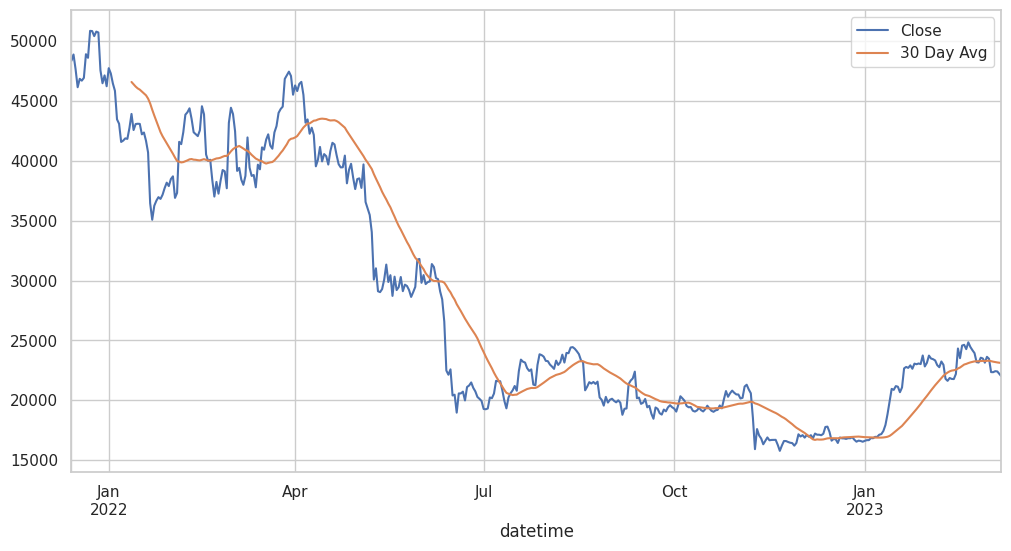

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style('whitegrid')

df['close'].plot(figsize=(12,6),label='Close')
df['close'].rolling(window=30).mean().plot(label='30 Day Avg')# Plotting the 

plt.legend()

In [ ]:
df['ohlc_average'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

In [ ]:
df['Price_After_Month']=df['close'].shift(-30) #This will be our label


In [ ]:
#Preprocessing
from sklearn import preprocessing
df.dropna(inplace=True)
X=df.drop('Price_After_Month',axis=1)
X=preprocessing.scale(X)#We need to scale our values to input them in our model
y=df['Price_After_Month']

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor(n_estimators=200,random_state=101)
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data

Accuracy is: 86.6024 %


In [ ]:
X_30=X[-30:]#We'll take the last 30 elements to make our predictions on them
forecast=reg.predict(X_30)

In [ ]:
#creating a new column which contains the predictions! 
#Proceed at your own risk!  
from datetime import datetime, timedelta
last_date=df.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=30,freq='D')
df1=pd.DataFrame(forecast,columns=['Forecast'],index=date)
df=df.append(df1)
df.tail()

/tmp/ipykernel_8463/787462399.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df1)


,open,high,low,close,ohlc_average,Price_After_Month,Forecast
2023-03-04,NaN,NaN,NaN,NaN,NaN,NaN,21472.84095
2023-03-05,NaN,NaN,NaN,NaN,NaN,NaN,21978.99945
2023-03-06,NaN,NaN,NaN,NaN,NaN,NaN,21993.08675
2023-03-07,NaN,NaN,NaN,NaN,NaN,NaN,21937.48115
2023-03-08,NaN,NaN,NaN,NaN,NaN,NaN,22396.28605


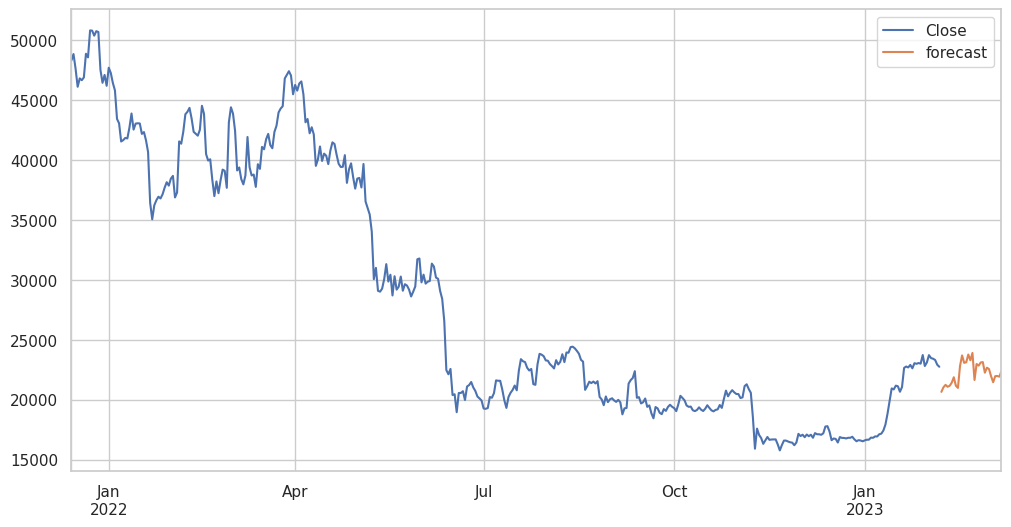

In [ ]:
#Now we'll plot our forecast! 
df['close'].plot(figsize=(12,6),label='Close')
df['Forecast'].plot(label='forecast')
plt.legend()